# Valley Extraction Tutorial
## Step-by-Step Walkthrough and Complete Workflow

# 1. Setup and Data Loading

### Imports

In [1]:
from loguru import logger
import matplotlib.pyplot as plt

from valleyx import delineate_reaches
from valleyx import flow_analysis
from valleyx import label_floors
from valleyx import detect_wallpoints
from valleyx import ValleyConfig
from valleyx import setup_wbt
from valleyx import load_input
from valleyx import extract_valleys

logger.disable("valleyx")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Data loading

In [2]:
dem, nhd_flowlines = load_input("./sample_data/1805000203-dem.tif", "./sample_data/1805000203-flowlines.shp")

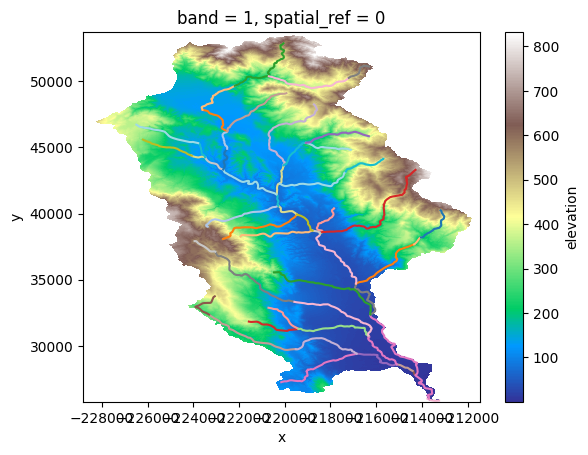

In [3]:
fig, ax = plt.subplots()
dem.plot(ax=ax, cmap='terrain')
for _,flow in nhd_flowlines.iterrows():
    ax.plot(*flow.geometry.xy, color=plt.cm.tab20(flow['OBJECTID'] % 20))

### Parameters

In [4]:
wbt = setup_wbt("./working_dir", verbose=False, max_procs=1) # make sure directory exists

In [5]:
cfg = ValleyConfig(
    # Reach delineation params
    hand_threshold=10,
    spacing=20,
    minsize=300,
    window=5,
    # Dem smoothing
    sigma=1.5,
    # Cross Section Params
    line_spacing=30,
    line_width=600,
    line_max_width=600,
    point_spacing=10,
    # Cross section preprocessing
    min_hand_jump=15,
    ratio=2.5,
    min_distance=20,
    min_peak_prominence=10,
    # Sustained slope params
    num_cells=8,
    slope_threshold=10,
    # Floor labeling params
    foundation_slope=5,
    buffer=1,
    min_points=15,
    percentile=0.80,
    max_floor_slope=14
)

# 2. Individual Steps

## 2.1 Flow Analysis

1. Compute flow direction and flow accumulation rasters for the digital elevation model
    - condition the dem by filling depressions and resolving flats
    - compute d8 flow directions
    - compute flow accumulation raster from flow directions 


  
2. Extract channel network for the flowlines vectors
    - extract channel heads by selecting cell with highest flow accumulation within neihborhood of the starting coordinates of the first order streams
    - trace flowpaths from the channel heads to the outlet(s) and assign IDs to the individual segments
    - vectorize flowpaths


   
3. Compute subbasins and hillslopes (drainage sides for each subbasin)
    - select all outlets and confluence cells and run watershed delineation
    - for each subbasin run connectivity algorithm to delineate the drainage sides of the stream


4. Compute HAND (Height Above Nearest Drainage)

In [6]:
flowlines, dataset = flow_analysis(dem, nhd_flowlines, wbt)

In [7]:
# resulting rasters:
# conditioned_dem - the dem with depressions filled and flats resolved
# flow_dir - d8 flow directions
# flow_acc - flow accumulation in number of cells for the flow directions
# flow_path - labeled channel, 0 is non channel
# subbasin - labeled subbasins for each channel ID
# hillslope - labeled drainage side for each subbasin
# hand - height above nearest channel
dataset.keys

<bound method Mapping.keys of <xarray.Dataset> Size: 194MB
Dimensions:          (x: 1735, y: 2793)
Coordinates:
    band             int64 8B 1
  * x                (x) float64 14kB -2.288e+05 -2.288e+05 ... -2.115e+05
  * y                (y) float64 22kB 5.371e+04 5.37e+04 ... 2.579e+04 2.578e+04
    spatial_ref      int64 8B 0
Data variables:
    conditioned_dem  (y, x) float64 39MB ...
    flow_dir         (y, x) float32 19MB ...
    flow_acc         (y, x) float32 19MB nan nan nan nan nan ... nan nan nan nan
    flow_path        (y, x) float32 19MB nan nan nan nan nan ... nan nan nan nan
    subbasin         (y, x) float64 39MB nan nan nan nan nan ... nan nan nan nan
    hillslope        (y, x) float32 19MB ...
    hand             (y, x) float64 39MB ...>

### Visualization of aligned flowlines compared to input flowlines

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleyx-_yJrOH5q-py3.10/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

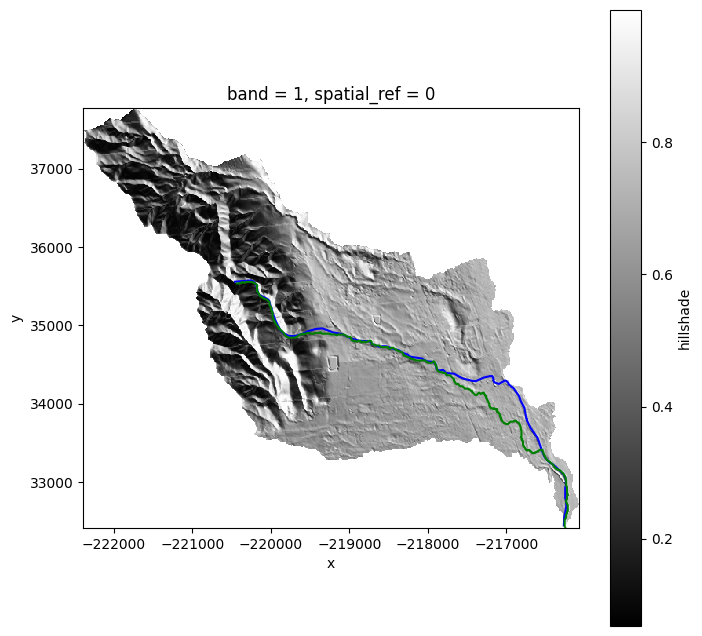

In [8]:
# focus on one channel
import xrspatial
from valleyx.raster.vectorize import shapes_from_binary_raster

def trim_raster(raster, mask):
    """Subset raster by mask and remove empty rows/columns"""
    masked = raster.where(mask)
    masked = raster.where(mask).dropna(dim='y', how='all').dropna(dim='x', how='all')
    return masked
    
roi = dataset['subbasin']== 17
roi_poly = shapes_from_binary_raster(roi)
# for better visual
hillshade = xrspatial.hillshade(dataset['conditioned_dem'])
hillshade_clipped = trim_raster(hillshade, roi)

# clip flowline and aligned flowlines
flowlines_clipped = nhd_flowlines.clip(roi_poly)
aligned_flowlines_clipped = flowlines.clip(roi_poly)

# plot 
fig, ax = plt.subplots(figsize=(8,8))
hillshade_clipped.plot(cmap='grey', ax=ax)
flowlines_clipped.plot(ax=ax, color='blue')
aligned_flowlines_clipped.plot(ax=ax, color='green')

## 2.2 Delineate Reaches

Reaches are delineated on the basis of changes in estimated valley bottom width
1. estimate valley bottom by applying constant threshold (cfg.hand_threshold) on the height above nearest drainage raster
2. genereate cross sections along the channel network and record valley bottom widths
3. find breakpoints using [linearly penalized segmentation](https://centre-borelli.github.io/ruptures-docs/user-guide/detection/pelt/)
4. recompute subbasins and hillslopes

In [9]:
flowlines_reaches, dataset = delineate_reaches(dataset, flowlines, wbt, hand_threshold=cfg.hand_threshold, spacing = cfg.spacing, minsize=cfg.minsize, window=cfg.window)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

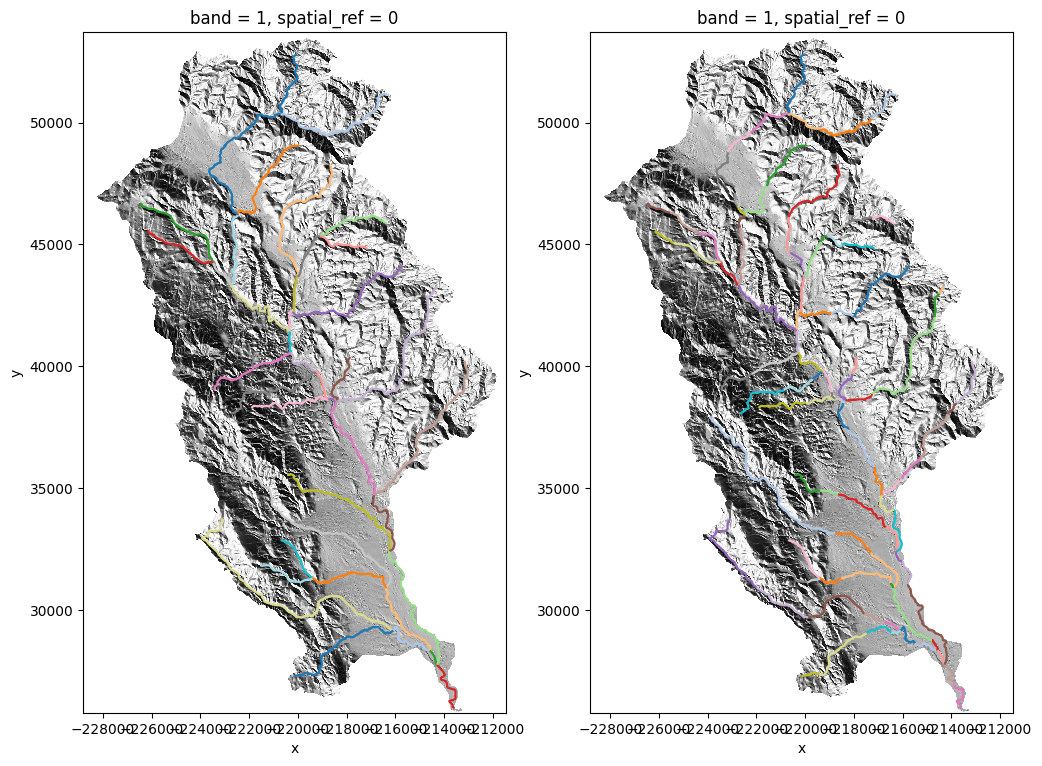

In [10]:
# visualize results
colors_r = [plt.cm.tab20(i % 20) for i in range(len(flowlines_reaches))]
colors = [plt.cm.tab20(i % 20) for i in range(len(flowlines))]

fig, axs = plt.subplots(1,2, figsize=(12,12))
hillshade.plot(ax=axs[0], cmap='grey', add_colorbar=False)
flowlines.plot(ax=axs[0], colors=colors_r)
hillshade.plot(ax=axs[1], cmap='grey', add_colorbar=False)
flowlines_reaches.plot(ax=axs[1], colors=colors_r)

## 2.3 Floor Labeling

### 2.3.1 Detecting valley wall boundary points

In [11]:
wallpoints = detect_wallpoints(dataset, flowlines_reaches, cfg.sigma, cfg.line_spacing, 
                               cfg.line_width, cfg.line_max_width, cfg.point_spacing, 
                               cfg.min_hand_jump, cfg.ratio, cfg.min_peak_prominence, cfg.min_distance, cfg.num_cells, cfg.slope_threshold, wbt)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

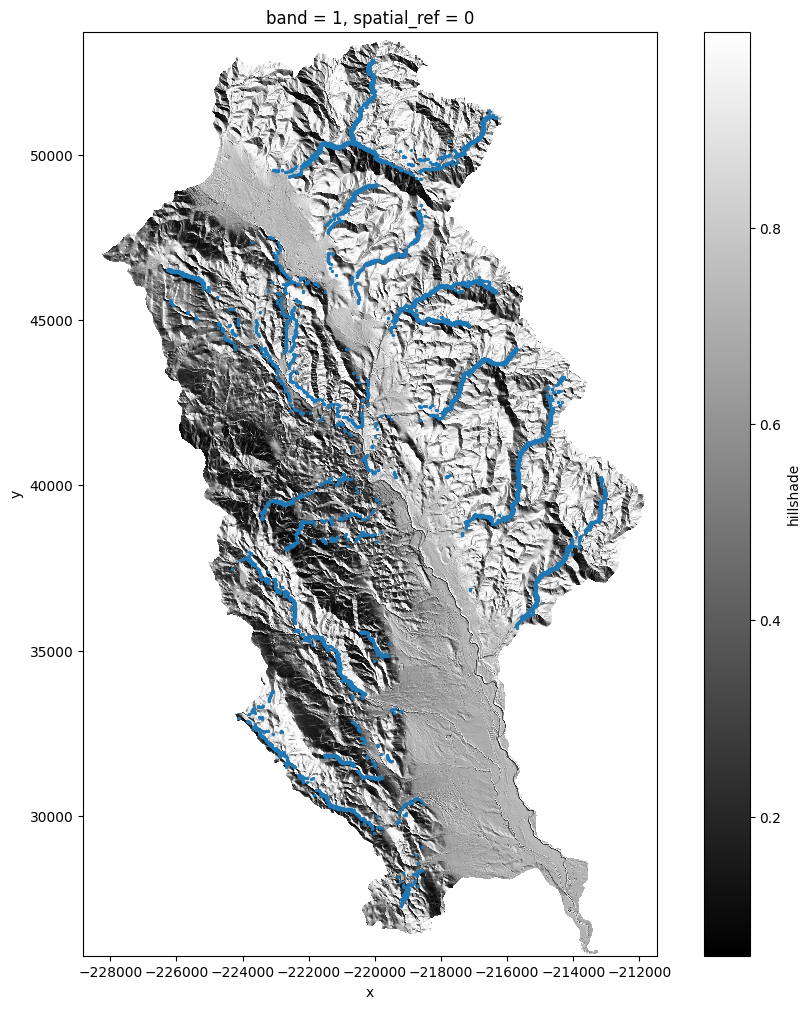

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
hillshade.plot(cmap='grey', ax=ax)
wallpoints.plot(ax=ax, markersize=2)

### 2.3.2 Flood to boundary points and combine with connected flat areas

In [13]:
floor = label_floors(wallpoints, dataset, cfg.max_floor_slope, cfg.foundation_slope, cfg.buffer, cfg.min_points, cfg.percentile)

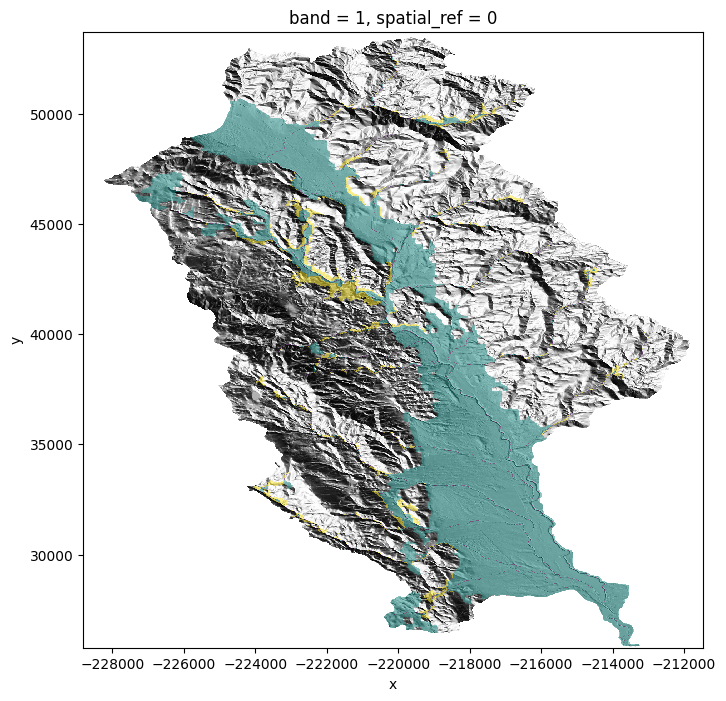

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
hillshade.plot(cmap='grey', ax=ax, add_colorbar=False)
floor.where(floor != 0).plot(ax=ax, add_colorbar=False, alpha=0.5)

# 3. Complete Workflow Using Main Function

In [15]:
result = extract_valleys(dem, nhd_flowlines, wbt, cfg)

In [16]:
result.keys

<function dict.keys>

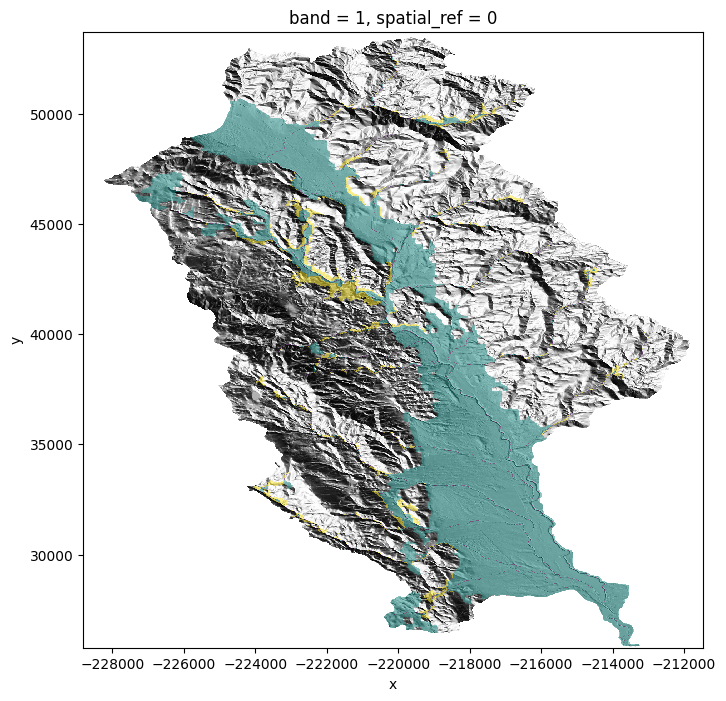

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
hillshade.plot(cmap='grey', ax=ax, add_colorbar=False)
result['floor'].where(floor != 0).plot(ax=ax, add_colorbar=False, alpha=0.5)